# Creating your own dataset from Google Images

by: Francisco Ingham and Jeremy Howard. Inspired by Adrian Rosebrock

In this tutorial we will see how to easily create an image dataset through Google Images. Note: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).

# Get a list of URLs

### Search and scroll

Go to [Google Images](https://images.google.com/?gws_rd=ssl) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

`"canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis`

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

## Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press `Ctrl+Shift+J` in Windows/Linux and `Cmd+Opt+J` in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. You can do this by running the following commands:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));```

## Create directory and upload urls file into your server


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

Choose an appropriate name for your labeled images. You can run these steps multiple times to grab different labels.

In [2]:
folder = 'Airplane'
file = 'urls-airplane.txt'

In [6]:
folder = 'Fighter-jets'
file = 'fighterjet.txt'

You will need to run this line once per each category.

In [3]:
path=Path('data/planes')


In [7]:
dest= path/folder
dest.mkdir(parents=True,exist_ok=True)

# Download images

Now you will need to download you images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename and the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

You will need to run this line once for every category.

In [4]:
classes =['Airplane','Fighter-jets']

In [8]:
download_images(file,dest,max_pics=800)

Then we can remove any images that can't be opened:

In [10]:
for c in classes:
    print(c)
    verify_images(path/c,delete=True)

# View data

In [5]:
np.random.seed(42)

data = ImageDataBunch.from_folder(path,train=".",valid_pct=0.2,
                                 ds_tfms= get_transforms(),size=224,bs=16).normalize(imagenet_stats)

In [7]:
data.classes

['Airplane', 'Fighter-jets']

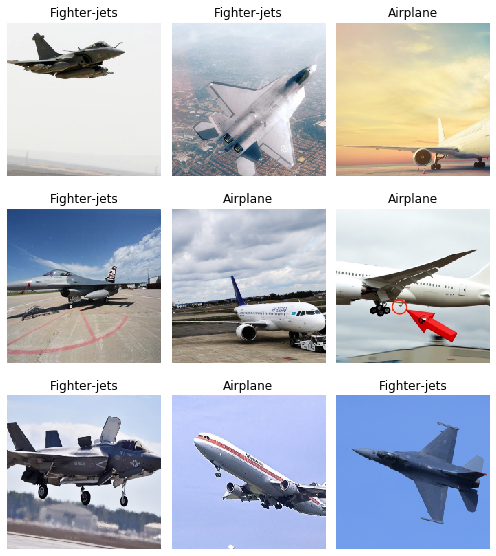

In [8]:
data.show_batch(rows=3,figsize=(7,8))

In [17]:
data.classes, data.c, len(data.train_ds),len(data.valid_ds)

(['Airplane', 'Fighter-jets'], 2, 525, 131)

# Model

In [7]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate)

In [10]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.623580,0.227979,0.106870,02:15
1,0.490452,0.228241,0.114504,02:11
2,0.367109,0.216910,0.099237,02:49
3,0.301519,0.227092,0.114504,02:34


In [11]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.259657,0.176450,0.068702,02:12
1,0.236298,0.180994,0.083969,02:13


In [12]:
learn.save('plane-1')

In [13]:
learn.unfreeze()

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


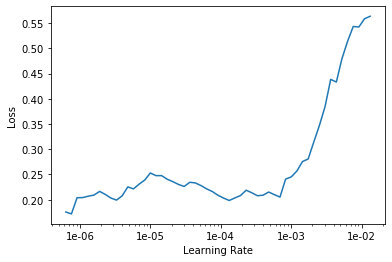

In [15]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.284995,0.179223,0.076336,01:14
1,0.218738,0.174894,0.068702,01:15
2,0.192641,0.167741,0.061069,01:18
3,0.172712,0.163132,0.061069,01:20


In [17]:
learn.fit_one_cycle(2,slice(3e-5,3e-4),moms=(0.85,0.85),wd=5e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.124234,0.164797,0.076336,02:26
1,0.127359,0.185438,0.076336,02:14


In [18]:
learn.save('plane-2')

# Interpretation

In [8]:
learn.load('plane-2');

In [9]:
interp = ClassificationInterpretation.from_learner(learn)

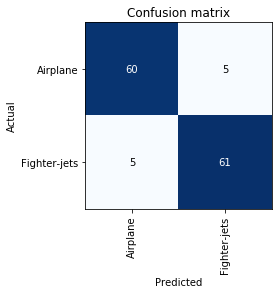

In [10]:
interp.plot_confusion_matrix()

In [11]:
losses, idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

#top_losses_path = data.valid_ds.x[idxs]

True

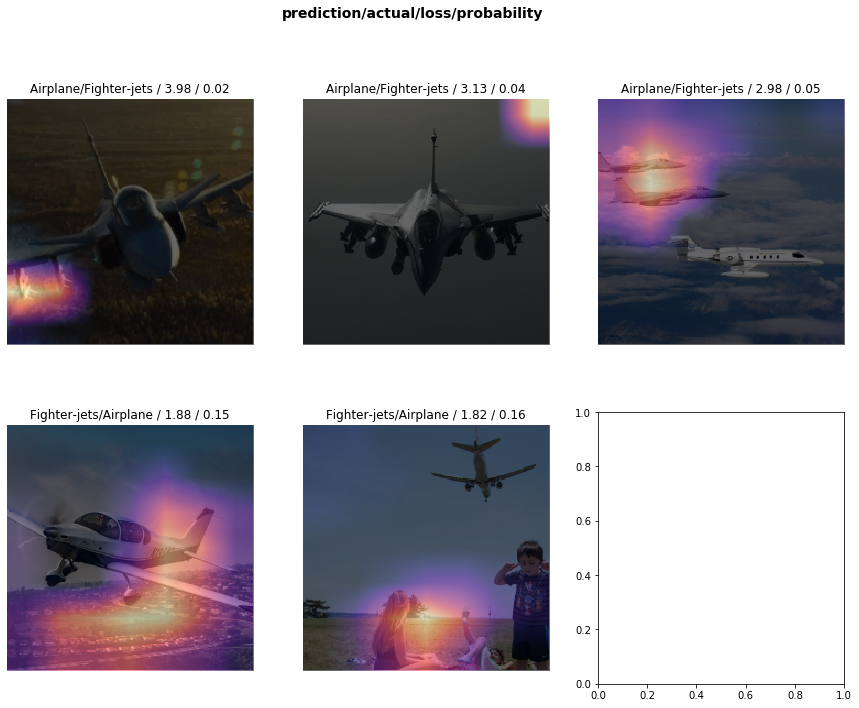

In [23]:
interp.plot_top_losses(5,figsize=(15,11))

# Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be there.

Using the `FileDeleter` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [12]:
from fastai.widgets import *
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

Now we can pass in these paths to our widget.

In [16]:
fd= ImageCleaner(ds,idxs,path)

'No images to show :)'

Flag photos for deletion by clicking 'Delete'. The `File_Deleter` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses`.

# Putting your model in production

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [ ]:
#fastai.defaults.device = torch.device('cpu')

In [18]:
data.classes

['Airplane', 'Fighter-jets']

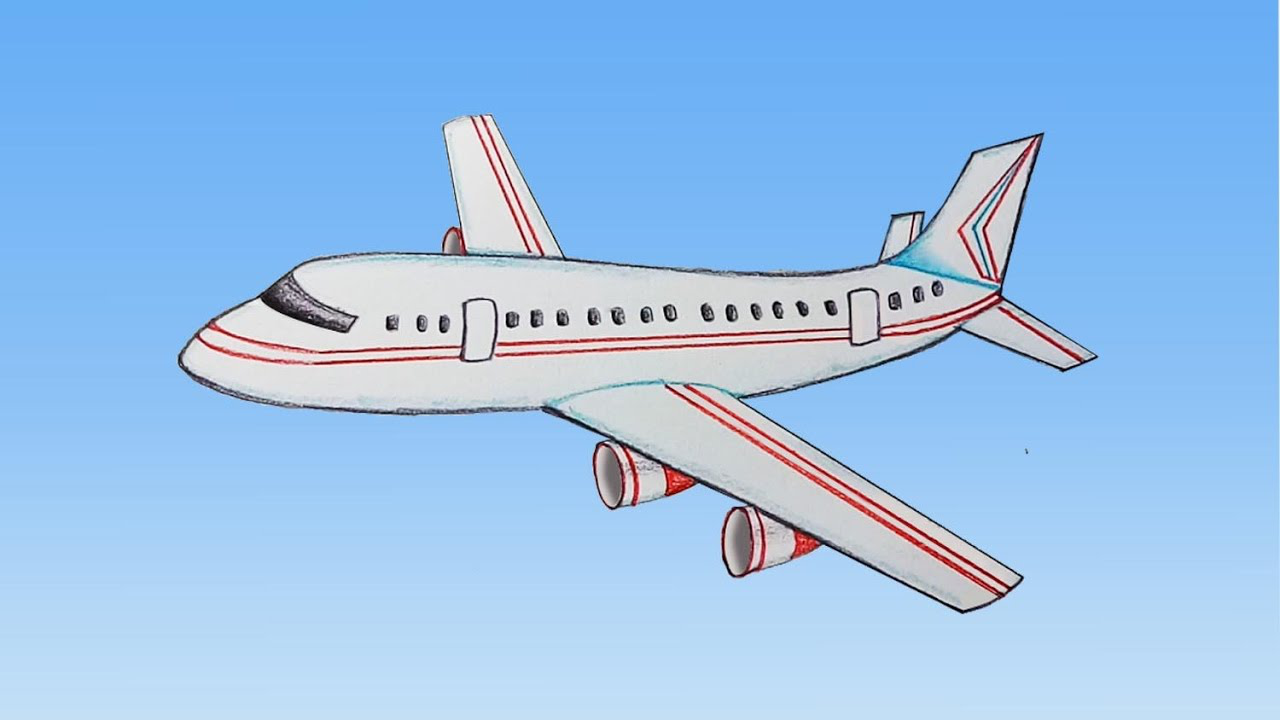

In [28]:
img = open_image(path/'test_image.jpg')
img

In [29]:
data2 = ImageDataBunch.single_from_classes(path,classes, ds_tfms=get_transforms(),
                                          size=224).normalize(imagenet_stats)

In [26]:
learn = cnn_learner(data2,models.resnet18).load('plane-2')

In [30]:
pred_class, pred_idx,outputs = learn.predict(img)
pred_class

Category Airplane

So you might create a route something like this (thanks to Simon Willison for the structure of this code):

```javascript
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })```